# Bidirectional RNNs

Keras provides an easy API for bulid bidirectional RNNs The **keras.layers.Bidirectional wrapper**

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Bidirectional will copy the RNN layer passed in, and flip.

The go_backward field of the newly copied layer,it will process the inputs in reverse order.

The concatenation of the forward layer output and backward layer output.

# Performance optimization and CuDNN kernels

keras.layers.CuDNNLDTM/CuDNNGRU layers have been deprecated and bulid your model without worrying about the hardware it will run on, not able to use the CuDNN kernel if you change the defaluts of the built-in LSTM or GRU layers.

Example:

* Using recurrent_dropout > 0.

* Changing the activation function from tanh to something else.

* Using masking when the input data is not strictly right padded

* Changing the recurrent_activation function from sigmoid to something else.

* Setting unroll to True, which forces LSTM/GRU to decompose the inner tf.while_loop into an unrolled for loop.

* Setting use_bias to False.



# Using CuDNN kernels when available

simple LSTM model to demonstrate the performance difference.

Input sequences the sequence of rows of MNIST digits and predict the digital label.

In [4]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Load the MNIST dataset:

In [5]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11493376/11490434 [==============================] - 0s 0us/step


Create a model and train the model.
sparse_categorical_crossentropy as the loss function for the model.

The model is an integer vector, each of the integer is in the range of 0 to 9

In [6]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 23s 22ms/step - loss: 0.9602 - accuracy: 0.6947 - val_loss: 0.6448 - val_accuracy: 0.7872


Compare to a model that does not use the CuDNN kernel:

In [7]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 21s 21ms/step - loss: 0.4382 - accuracy: 0.8642 - val_loss: 0.3000 - val_accuracy: 0.9087


CuDNN is much faster to train compared to the model that uses the regular Tensoflow kernel, run inference in a CPU- only environment, the model will run on CPU by default if no GPU is available

Predicted result is: [3], target result is: 5


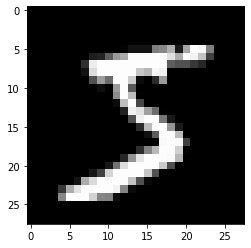

In [8]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

# RNNs with list/dict input, or nested inputs

The data shape in this case could be like 
[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]

one more example, handwriting data could have both coordinates x and y for the current position of the pen, as well as pressure information. So the data representation could be:

[batch, timestep, {"location": [x, y], "pressure": [force]}]

<h4> Define a custom cell that supports nested input/output

In [9]:

class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


<h4>Build a RNN model with nested input/output

In [10]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

<h4> Train the model with randomly generated data</h4>

In [11]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 8s 659ms/step - loss: 0.7763 - rnn_1_loss: 0.2885 - rnn_1_1_loss: 0.4878 - rnn_1_accuracy: 0.0875 - rnn_1_1_accuracy: 0.0352


Using keras.layers.RNN layer just expected to define the math logic for individual step within the sequence and the keras.layers.RNN layer will handle the sequence iteration.